In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Load your scored customer data
df = pd.read_csv('churn_scores.csv')
df_main = pd.read_csv('saas_churn_data.csv')

# Merge to get all columns
df_full = df_main.merge(
    df[['Customer_ID', 'Churn_Probability', 'Risk_Tier', 'Churn_Probability_Pct']],
    on='Customer_ID', how='left'
)

print(f"Data loaded: {len(df_full):,} customers")
print(f"Columns: {df_full.columns.tolist()}")

Data loaded: 5,000 customers
Columns: ['Customer_ID', 'Signup_Date', 'Plan', 'Contract_Type', 'Industry', 'Acquisition_Channel', 'Monthly_Spend_USD', 'Tenure_Months', 'Num_Users', 'Logins_Per_Month', 'Features_Used', 'API_Calls_Monthly', 'Support_Tier', 'Support_Tickets_6M', 'Days_Since_Last_Login', 'Payment_Failures', 'NPS_Score', 'Churned', 'Churn_Date', 'Churn_Reason', 'Churn_Probability', 'Risk_Tier', 'Churn_Probability_Pct']


# SaaS Churn — Business Impact & Retention Strategy
## Purpose
This notebook translates the churn prediction model outputs into 
quantified business impact, expected revenue uplift from retention 
actions, and a prioritised recommendation framework.

Current state business impact:

In [2]:
# === CURRENT STATE METRICS ===
total_customers = len(df_full)
churned = df_full['Churned'].sum()
retained = total_customers - churned
churn_rate = churned / total_customers

# Revenue metrics
total_monthly_revenue = df_full['Monthly_Spend_USD'].sum()
churned_monthly_revenue = df_full[df_full['Churned']==1]['Monthly_Spend_USD'].sum()
retained_monthly_revenue = df_full[df_full['Churned']==0]['Monthly_Spend_USD'].sum()

# Customer Lifetime Value (assuming avg 24 month retention for non-churners)
avg_tenure_churned = df_full[df_full['Churned']==1]['Tenure_Months'].mean()
avg_tenure_retained = df_full[df_full['Churned']==0]['Tenure_Months'].mean()
avg_monthly_spend = df_full['Monthly_Spend_USD'].mean()

clv_churned = avg_tenure_churned * avg_monthly_spend
clv_retained = avg_tenure_retained * avg_monthly_spend

# Annual revenue lost to churn
annual_revenue_lost = churned_monthly_revenue * 12

print("=" * 55)
print("      CURRENT STATE — BUSINESS IMPACT SUMMARY")
print("=" * 55)
print(f"\nTotal Customers:              {total_customers:,}")
print(f"Churned Customers:            {churned:,} ({churn_rate*100:.1f}%)")
print(f"Retained Customers:           {retained:,}")
print(f"\nMonthly Revenue Base:         ${total_monthly_revenue:,.0f}")
print(f"Monthly Revenue Lost:         ${churned_monthly_revenue:,.0f}")
print(f"Annual Revenue Lost:          ${annual_revenue_lost:,.0f}")
print(f"\nAvg CLV — Churned Customer:   ${clv_churned:,.0f}")
print(f"Avg CLV — Retained Customer:  ${clv_retained:,.0f}")
print(f"CLV Gap:                      ${clv_retained - clv_churned:,.0f} per customer")
print(f"\nIf churn reduced by just 5%:  ${annual_revenue_lost * 0.05:,.0f} saved annually")
print(f"If churn reduced by 10%:      ${annual_revenue_lost * 0.10:,.0f} saved annually")
print(f"If churn reduced by 20%:      ${annual_revenue_lost * 0.20:,.0f} saved annually")

      CURRENT STATE — BUSINESS IMPACT SUMMARY

Total Customers:              5,000
Churned Customers:            1,560 (31.2%)
Retained Customers:           3,440

Monthly Revenue Base:         $896,830
Monthly Revenue Lost:         $199,353
Annual Revenue Lost:          $2,392,233

Avg CLV — Churned Customer:   $1,494
Avg CLV — Retained Customer:  $1,576
CLV Gap:                      $82 per customer

If churn reduced by just 5%:  $119,612 saved annually
If churn reduced by 10%:      $239,223 saved annually
If churn reduced by 20%:      $478,447 saved annually


Business impact by plan tier:

=== BUSINESS IMPACT BY PLAN TIER ===



,Plan,Total_Customers,Churned_Customers,Churn_Rate,Annual_Revenue_Lost,Priority
0,Business,1263,298,23.6,979434.72,High
1,Enterprise,499,66,13.2,522509.04,High
2,Professional,1529,467,30.5,610472.28,High
3,Starter,1709,729,42.7,279817.08,Medium


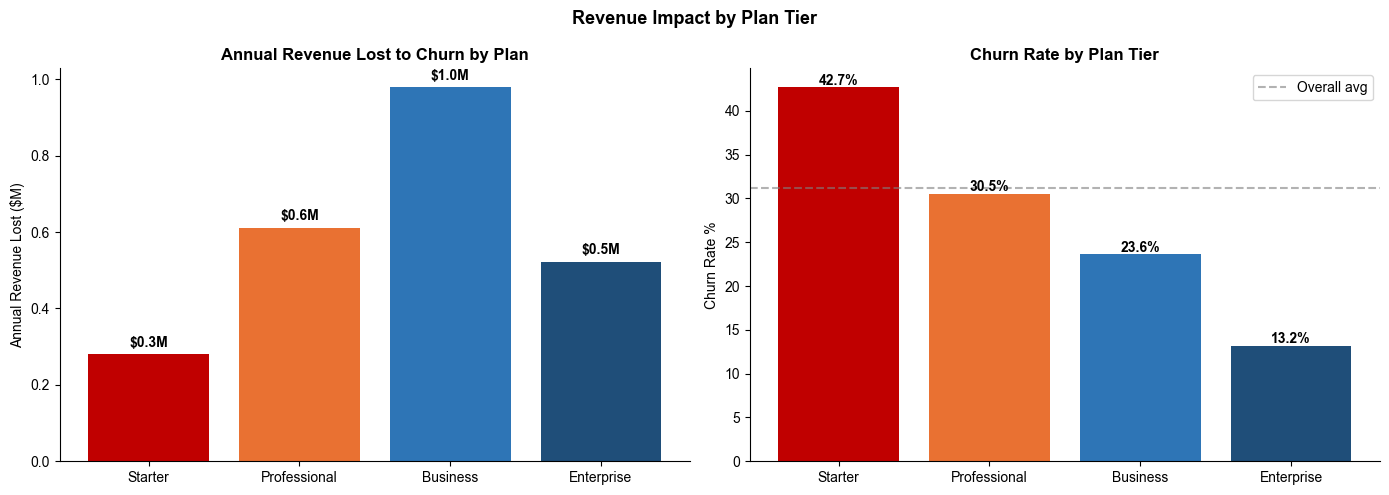

In [3]:
plan_impact = df_full.groupby('Plan').agg(
    Total_Customers=('Customer_ID', 'count'),
    Churned_Customers=('Churned', 'sum'),
    Churn_Rate=('Churned', 'mean'),
    Monthly_Revenue=('Monthly_Spend_USD', 'sum'),
    Churned_Revenue=('Monthly_Spend_USD', lambda x: x[df_full.loc[x.index, 'Churned']==1].sum()),
    Avg_Monthly_Spend=('Monthly_Spend_USD', 'mean')
).reset_index()

plan_impact['Annual_Revenue_Lost'] = plan_impact['Churned_Revenue'] * 12
plan_impact['Churn_Rate'] = (plan_impact['Churn_Rate'] * 100).round(1)
plan_impact['Priority'] = plan_impact.apply(
    lambda x: 'Critical' if x['Annual_Revenue_Lost'] > 1000000
    else 'High' if x['Annual_Revenue_Lost'] > 500000
    else 'Medium', axis=1
)

print("=== BUSINESS IMPACT BY PLAN TIER ===\n")
display(plan_impact[['Plan', 'Total_Customers', 'Churned_Customers',
                      'Churn_Rate', 'Annual_Revenue_Lost', 'Priority']])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plan_order = ['Starter', 'Professional', 'Business', 'Enterprise']
plan_data = plan_impact.set_index('Plan').reindex(plan_order)

bars = axes[0].bar(plan_data.index, plan_data['Annual_Revenue_Lost']/1e6,
                   color=['#C00000', '#E97132', '#2E75B6', '#1F4E79'])
for bar, val in zip(bars, plan_data['Annual_Revenue_Lost']):
    axes[0].text(bar.get_x() + bar.get_width()/2, val/1e6 + 0.02,
                f'${val/1e6:.1f}M', ha='center', fontweight='bold', fontsize=10)
axes[0].set_ylabel('Annual Revenue Lost ($M)')
axes[0].set_title('Annual Revenue Lost to Churn by Plan', fontweight='bold')

bars2 = axes[1].bar(plan_data.index, plan_data['Churn_Rate'],
                    color=['#C00000', '#E97132', '#2E75B6', '#1F4E79'])
for bar, val in zip(bars2, plan_data['Churn_Rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.3,
                f'{val}%', ha='center', fontweight='bold', fontsize=10)
axes[1].set_ylabel('Churn Rate %')
axes[1].set_title('Churn Rate by Plan Tier', fontweight='bold')
axes[1].axhline(y=df_full['Churned'].mean()*100, color='grey',
                linestyle='--', alpha=0.6, label='Overall avg')
axes[1].legend()

plt.suptitle('Revenue Impact by Plan Tier', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('impact_chart1_plan_tier.png', dpi=150, bbox_inches='tight')
plt.show()

Business impact by contract type:

=== BUSINESS IMPACT BY CONTRACT TYPE ===



,Contract_Type,Total_Customers,Churned_Customers,Churn_Rate,Churned_Revenue,Avg_Tenure,Annual_Revenue_Lost
0,Annual,1989,473,23.8,62063.88,8.546506,744766.56
1,Monthly,2295,990,43.1,123558.64,8.675817,1482703.68
2,Two-Year,716,97,13.5,13730.24,8.801676,164762.88


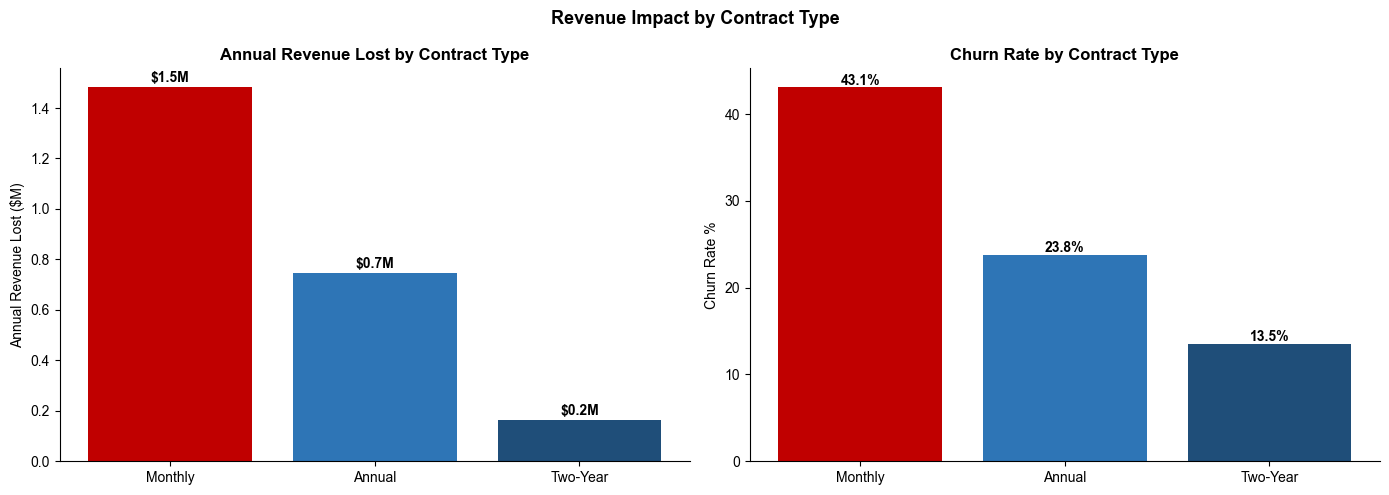


Insight: Monthly contract customers churn at 3.2x the rate of Two-Year customers
Converting monthly to annual contracts is the single highest-impact retention lever


In [4]:
contract_impact = df_full.groupby('Contract_Type').agg(
    Total_Customers=('Customer_ID', 'count'),
    Churned_Customers=('Churned', 'sum'),
    Churn_Rate=('Churned', 'mean'),
    Churned_Revenue=('Monthly_Spend_USD',
                     lambda x: x[df_full.loc[x.index, 'Churned']==1].sum()),
    Avg_Tenure=('Tenure_Months', 'mean')
).reset_index()

contract_impact['Annual_Revenue_Lost'] = contract_impact['Churned_Revenue'] * 12
contract_impact['Churn_Rate'] = (contract_impact['Churn_Rate'] * 100).round(1)

print("=== BUSINESS IMPACT BY CONTRACT TYPE ===\n")
display(contract_impact)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

contract_order = ['Monthly', 'Annual', 'Two-Year']
contract_data = contract_impact.set_index('Contract_Type').reindex(contract_order)

bars = axes[0].bar(contract_data.index, contract_data['Annual_Revenue_Lost']/1e6,
                   color=['#C00000', '#2E75B6', '#1F4E79'])
for bar, val in zip(bars, contract_data['Annual_Revenue_Lost']):
    axes[0].text(bar.get_x() + bar.get_width()/2, val/1e6 + 0.02,
                f'${val/1e6:.1f}M', ha='center', fontweight='bold', fontsize=10)
axes[0].set_ylabel('Annual Revenue Lost ($M)')
axes[0].set_title('Annual Revenue Lost by Contract Type', fontweight='bold')

bars2 = axes[1].bar(contract_data.index, contract_data['Churn_Rate'],
                    color=['#C00000', '#2E75B6', '#1F4E79'])
for bar, val in zip(bars2, contract_data['Churn_Rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.3,
                f'{val}%', ha='center', fontweight='bold', fontsize=10)
axes[1].set_ylabel('Churn Rate %')
axes[1].set_title('Churn Rate by Contract Type', fontweight='bold')

plt.suptitle('Revenue Impact by Contract Type', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('impact_chart2_contract.png', dpi=150, bbox_inches='tight')
plt.show()

monthly_vs_twoyear = contract_data.loc['Monthly', 'Churn_Rate'] / contract_data.loc['Two-Year', 'Churn_Rate']
print(f"\nInsight: Monthly contract customers churn at {monthly_vs_twoyear:.1f}x the rate of Two-Year customers")
print(f"Converting monthly to annual contracts is the single highest-impact retention lever")

Industry and acquisition channel impact:

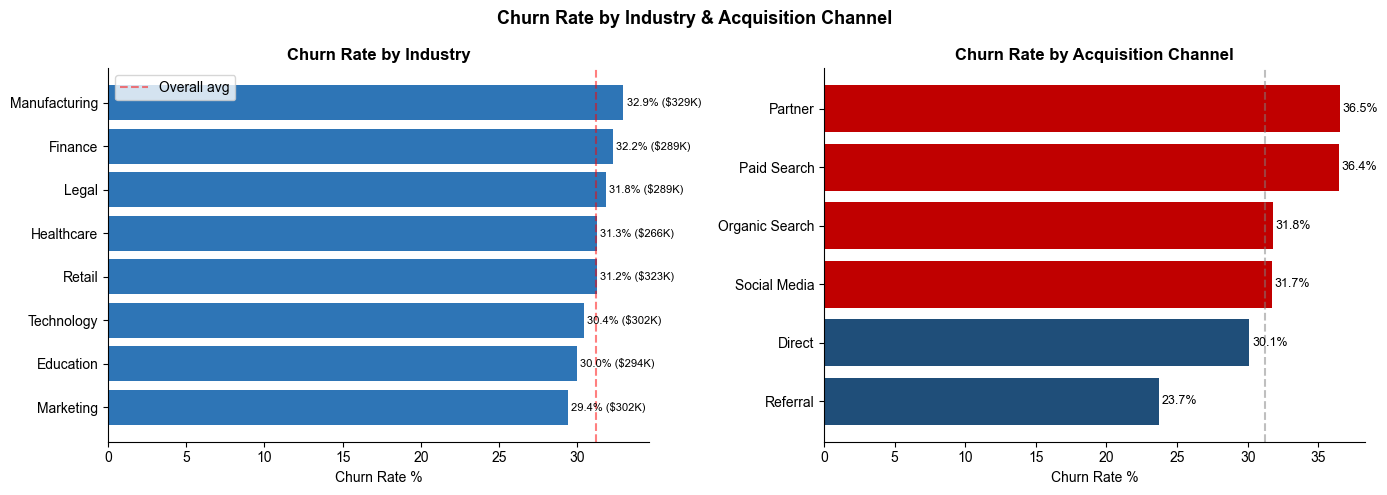

Best channel: Referral — 23.7% churn
Worst channel: Partner — 36.5% churn


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Industry churn rate
industry_churn = df_full.groupby('Industry').agg(
    Churn_Rate=('Churned', 'mean'),
    Revenue_At_Risk=('Monthly_Spend_USD',
                     lambda x: x[df_full.loc[x.index, 'Churned']==1].sum() * 12)
).reset_index().sort_values('Churn_Rate', ascending=True)

axes[0].barh(industry_churn['Industry'], industry_churn['Churn_Rate']*100,
             color='#2E75B6')
for i, (rate, rev) in enumerate(zip(industry_churn['Churn_Rate'],
                                     industry_churn['Revenue_At_Risk'])):
    axes[0].text(rate*100 + 0.2, i,
                f'{rate*100:.1f}% (${rev/1e3:.0f}K)', va='center', fontsize=8)
axes[0].set_xlabel('Churn Rate %')
axes[0].set_title('Churn Rate by Industry', fontweight='bold')
axes[0].axvline(x=df_full['Churned'].mean()*100, color='red',
                linestyle='--', alpha=0.5, label='Overall avg')
axes[0].legend()

# Acquisition channel
channel_churn = df_full.groupby('Acquisition_Channel').agg(
    Churn_Rate=('Churned', 'mean'),
    Customer_Count=('Customer_ID', 'count'),
    Revenue_At_Risk=('Monthly_Spend_USD',
                     lambda x: x[df_full.loc[x.index, 'Churned']==1].sum() * 12)
).reset_index().sort_values('Churn_Rate', ascending=True)

colors_channel = ['#1F4E79' if x < df_full['Churned'].mean()
                  else '#C00000' for x in channel_churn['Churn_Rate']]
axes[1].barh(channel_churn['Acquisition_Channel'],
             channel_churn['Churn_Rate']*100, color=colors_channel)
for i, rate in enumerate(channel_churn['Churn_Rate']):
    axes[1].text(rate*100 + 0.2, i, f'{rate*100:.1f}%', va='center', fontsize=9)
axes[1].set_xlabel('Churn Rate %')
axes[1].set_title('Churn Rate by Acquisition Channel', fontweight='bold')
axes[1].axvline(x=df_full['Churned'].mean()*100, color='grey',
                linestyle='--', alpha=0.5)

plt.suptitle('Churn Rate by Industry & Acquisition Channel',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('impact_chart3_industry_channel.png', dpi=150, bbox_inches='tight')
plt.show()

best_channel = channel_churn.iloc[0]
worst_channel = channel_churn.iloc[-1]
print(f"Best channel: {best_channel['Acquisition_Channel']} — {best_channel['Churn_Rate']*100:.1f}% churn")
print(f"Worst channel: {worst_channel['Acquisition_Channel']} — {worst_channel['Churn_Rate']*100:.1f}% churn")

## Addition 2 — Expected Revenue Uplift from Retention Actions
Quantifying the financial return of each proposed retention intervention.
This translates recommendations from 'good ideas' into business cases 
with projected ROI — the difference between an analyst and a BA.

Define and calculate uplift per intervention:

In [6]:
# Base metrics
monthly_revenue_lost = 199353
annual_revenue_lost = 2392233
high_risk_customers = df_full[df_full['Risk_Tier'] == 'High Risk']
medium_risk_customers = df_full[df_full['Risk_Tier'] == 'Medium Risk']
monthly_contracts = df_full[df_full['Contract_Type'] == 'Monthly']
starter_customers = df_full[df_full['Plan'] == 'Starter']

print("=== RETENTION INTERVENTION UPLIFT CALCULATIONS ===\n")

# Intervention 1 — Annual Contract Incentive for Monthly Customers
monthly_churners = df_full[
    (df_full['Contract_Type'] == 'Monthly') & (df_full['Churned'] == 1)
]
monthly_churn_revenue = monthly_churners['Monthly_Spend_USD'].sum() * 12
conversion_rate = 0.25  # assume 25% of monthly churners convert to annual
discount_offered = 0.10  # 10% discount for annual commitment
uplift_1 = monthly_churn_revenue * conversion_rate * (1 - discount_offered)
cost_1 = monthly_churn_revenue * conversion_rate * discount_offered

print("INTERVENTION 1: Annual Contract Incentive for Monthly Customers")
print(f"  Monthly contract churners annual revenue lost: ${monthly_churn_revenue:,.0f}")
print(f"  Assumed conversion rate to annual: {conversion_rate*100:.0f}%")
print(f"  Discount offered: {discount_offered*100:.0f}%")
print(f"  → Net Revenue Uplift: ${uplift_1:,.0f}")
print(f"  → Cost of Discount: ${cost_1:,.0f}")
print(f"  → ROI: {uplift_1/cost_1:.1f}x\n")

# Intervention 2 — High Risk Customer Outreach Program
high_risk_churners = df_full[
    (df_full['Risk_Tier'] == 'High Risk') & (df_full['Churned'] == 1)
]
high_risk_revenue = high_risk_churners['Monthly_Spend_USD'].sum() * 12
save_rate = 0.30  # 30% save rate with personal outreach
cost_per_save = 150  # CSM time per saved customer
customers_saved = len(high_risk_churners) * save_rate
uplift_2 = high_risk_revenue * save_rate
cost_2 = customers_saved * cost_per_save

print("INTERVENTION 2: High Risk Customer Outreach Program")
print(f"  High risk churners annual revenue: ${high_risk_revenue:,.0f}")
print(f"  Expected save rate with CSM outreach: {save_rate*100:.0f}%")
print(f"  Estimated customers saved: {customers_saved:.0f}")
print(f"  Cost per saved customer (CSM time): ${cost_per_save}")
print(f"  → Net Revenue Uplift: ${uplift_2:,.0f}")
print(f"  → Program Cost: ${cost_2:,.0f}")
print(f"  → ROI: {uplift_2/cost_2:.1f}x\n")

# Intervention 3 — NPS Detractor Recovery Program
detractors = df_full[
    (df_full['NPS_Score'] <= 3) & (df_full['Churned'] == 1)
]
detractor_revenue = detractors['Monthly_Spend_USD'].sum() * 12
recovery_rate = 0.20
uplift_3 = detractor_revenue * recovery_rate
cost_3 = len(detractors) * recovery_rate * 200  # $200 per recovery (support + offer)

print("INTERVENTION 3: NPS Detractor Recovery Program")
print(f"  Detractor churners annual revenue: ${detractor_revenue:,.0f}")
print(f"  Expected recovery rate: {recovery_rate*100:.0f}%")
print(f"  → Net Revenue Uplift: ${uplift_3:,.0f}")
print(f"  → Program Cost: ${cost_3:,.0f}")
print(f"  → ROI: {uplift_3/cost_3:.1f}x\n")

# Intervention 4 — Feature Adoption Campaign for Low Usage Customers
low_usage = df_full[
    (df_full['Features_Used'] < 5) & (df_full['Churned'] == 1)
]
low_usage_revenue = low_usage['Monthly_Spend_USD'].sum() * 12
adoption_save_rate = 0.15
uplift_4 = low_usage_revenue * adoption_save_rate
cost_4 = len(low_usage) * 50  # $50 per customer for email campaign

print("INTERVENTION 4: Feature Adoption Campaign")
print(f"  Low usage churners annual revenue: ${low_usage_revenue:,.0f}")
print(f"  Expected save rate from adoption campaign: {adoption_save_rate*100:.0f}%")
print(f"  → Net Revenue Uplift: ${uplift_4:,.0f}")
print(f"  → Campaign Cost: ${cost_4:,.0f}")
print(f"  → ROI: {uplift_4/cost_4:.1f}x\n")

# Intervention 5 — Starter Plan Upgrade Incentive
starter_churners = df_full[
    (df_full['Plan'] == 'Starter') & (df_full['Churned'] == 1)
]
upgrade_rate = 0.12
upgrade_revenue = len(starter_churners) * upgrade_rate * 70 * 12  # $70 more per month
uplift_5 = upgrade_revenue
cost_5 = len(starter_churners) * upgrade_rate * 30 * 3  # 3 months discount

print("INTERVENTION 5: Starter Plan Upgrade Incentive")
print(f"  Starter plan churners: {len(starter_churners):,}")
print(f"  Expected upgrade rate: {upgrade_rate*100:.0f}%")
print(f"  → Net Revenue Uplift: ${uplift_5:,.0f}")
print(f"  → Incentive Cost: ${cost_5:,.0f}")
print(f"  → ROI: {uplift_5/cost_5:.1f}x\n")

total_uplift = uplift_1 + uplift_2 + uplift_3 + uplift_4 + uplift_5
total_cost = cost_1 + cost_2 + cost_3 + cost_4 + cost_5
print("=" * 55)
print(f"TOTAL EXPECTED UPLIFT:  ${total_uplift:,.0f}")
print(f"TOTAL PROGRAM COST:     ${total_cost:,.0f}")
print(f"OVERALL ROI:            {total_uplift/total_cost:.1f}x")
print(f"% OF LOST REVENUE RECOVERED: {total_uplift/annual_revenue_lost*100:.1f}%")

=== RETENTION INTERVENTION UPLIFT CALCULATIONS ===

INTERVENTION 1: Annual Contract Incentive for Monthly Customers
  Monthly contract churners annual revenue lost: $1,482,704
  Assumed conversion rate to annual: 25%
  Discount offered: 10%
  → Net Revenue Uplift: $333,608
  → Cost of Discount: $37,068
  → ROI: 9.0x

INTERVENTION 2: High Risk Customer Outreach Program
  High risk churners annual revenue: $1,058,641
  Expected save rate with CSM outreach: 30%
  Estimated customers saved: 288
  Cost per saved customer (CSM time): $150
  → Net Revenue Uplift: $317,592
  → Program Cost: $43,200
  → ROI: 7.4x

INTERVENTION 3: NPS Detractor Recovery Program
  Detractor churners annual revenue: $1,104,116
  Expected recovery rate: 20%
  → Net Revenue Uplift: $220,823
  → Program Cost: $27,320
  → ROI: 8.1x

INTERVENTION 4: Feature Adoption Campaign
  Low usage churners annual revenue: $666,791
  Expected save rate from adoption campaign: 15%
  → Net Revenue Uplift: $100,019
  → Campaign Cost:

Uplift summary table:

In [7]:
uplift_summary = pd.DataFrame({
    'Intervention': [
        'Annual Contract Incentive',
        'High Risk Customer Outreach',
        'NPS Detractor Recovery',
        'Feature Adoption Campaign',
        'Starter Plan Upgrade Incentive'
    ],
    'Target_Segment': [
        'Monthly contract customers',
        'High Risk score customers',
        'NPS score 1-3 customers',
        'Customers using <5 features',
        'Starter plan customers'
    ],
    'Expected_Uplift_USD': [
        uplift_1, uplift_2, uplift_3, uplift_4, uplift_5
    ],
    'Program_Cost_USD': [
        cost_1, cost_2, cost_3, cost_4, cost_5
    ],
    'ROI': [
        round(uplift_1/cost_1, 1),
        round(uplift_2/cost_2, 1),
        round(uplift_3/cost_3, 1),
        round(uplift_4/cost_4, 1),
        round(uplift_5/cost_5, 1)
    ],
    'Timeline': [
        '1-3 months',
        '0-1 months',
        '1-2 months',
        '2-4 months',
        '3-6 months'
    ]
})

uplift_summary = uplift_summary.sort_values('Expected_Uplift_USD', ascending=False)
uplift_summary['Expected_Uplift_USD'] = uplift_summary['Expected_Uplift_USD'].apply(lambda x: f'${x:,.0f}')
uplift_summary['Program_Cost_USD'] = uplift_summary['Program_Cost_USD'].apply(lambda x: f'${x:,.0f}')

print("=== RETENTION INTERVENTION UPLIFT SUMMARY ===\n")
display(uplift_summary)
uplift_summary.to_excel('retention_uplift.xlsx', index=False)
print("\nUplift summary saved")

=== RETENTION INTERVENTION UPLIFT SUMMARY ===



,Intervention,Target_Segment,Expected_Uplift_USD,Program_Cost_USD,ROI,Timeline
0,Annual Contract Incentive,Monthly contract customers,"$333,608","$37,068",9.0,1-3 months
1,High Risk Customer Outreach,High Risk score customers,"$317,592","$43,200",7.4,0-1 months
2,NPS Detractor Recovery,NPS score 1-3 customers,"$220,823","$27,320",8.1,1-2 months
3,Feature Adoption Campaign,Customers using <5 features,"$100,019","$20,100",5.0,2-4 months
4,Starter Plan Upgrade Incentive,Starter plan customers,"$73,483","$7,873",9.3,3-6 months



Uplift summary saved


Impact vs Effort Matrix

Build the Impact vs Effort Matrix:

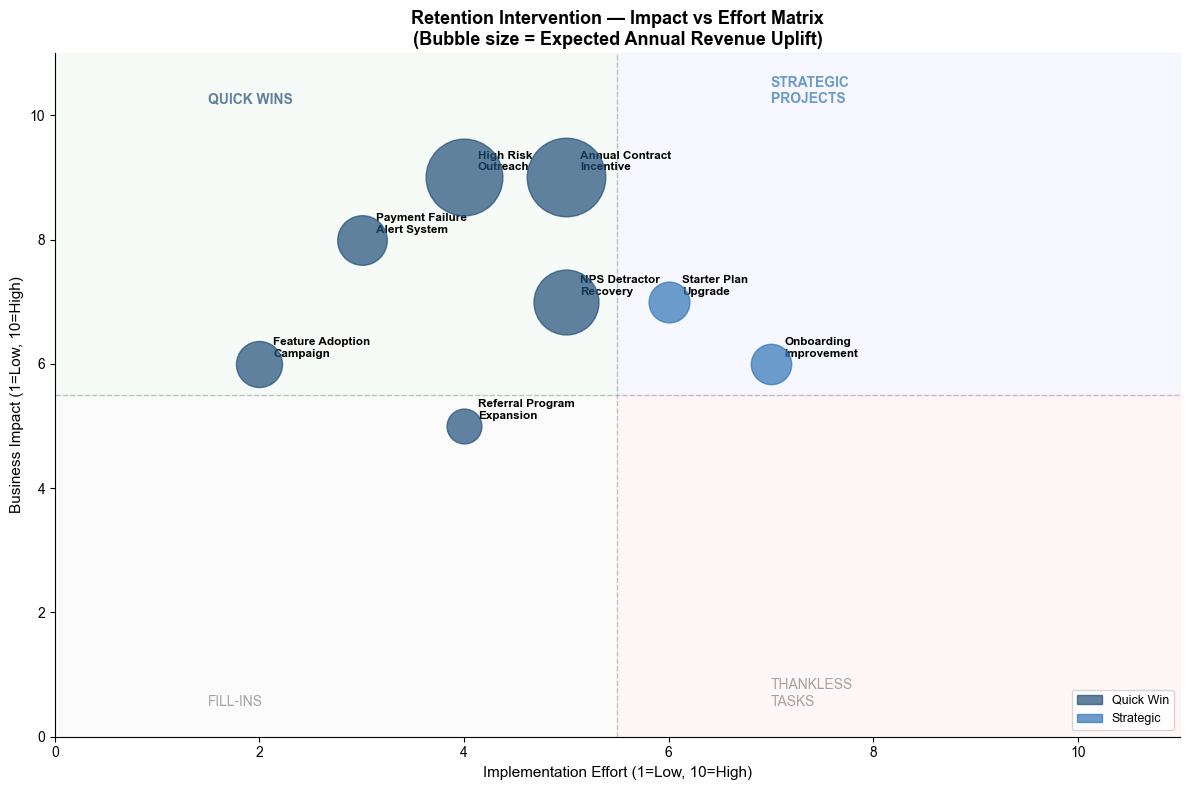

Impact vs Effort Matrix saved

Quick Wins — implement immediately:
  • High Risk Outreach — Impact: 9/10, Effort: 4/10
  • Annual Contract Incentive — Impact: 9/10, Effort: 5/10
  • Payment Failure Alert System — Impact: 8/10, Effort: 3/10
  • NPS Detractor Recovery — Impact: 7/10, Effort: 5/10
  • Feature Adoption Campaign — Impact: 6/10, Effort: 2/10
  • Referral Program Expansion — Impact: 5/10, Effort: 4/10


In [8]:
interventions = {
    'Intervention': [
        'High Risk\nOutreach',
        'Annual Contract\nIncentive',
        'NPS Detractor\nRecovery',
        'Feature Adoption\nCampaign',
        'Starter Plan\nUpgrade',
        'Payment Failure\nAlert System',
        'Onboarding\nImprovement',
        'Referral Program\nExpansion'
    ],
    'Impact_Score': [9, 9, 7, 6, 7, 8, 6, 5],
    'Effort_Score': [4, 5, 5, 2, 6, 3, 7, 4],
    'Annual_Uplift': [
        uplift_2, uplift_1, uplift_3, uplift_4, uplift_5,
        annual_revenue_lost * 0.05,
        annual_revenue_lost * 0.03,
        annual_revenue_lost * 0.02
    ],
    'Priority': [
        'Quick Win', 'Quick Win', 'Quick Win',
        'Quick Win', 'Strategic', 'Quick Win',
        'Strategic', 'Quick Win'
    ]
}

df_matrix = pd.DataFrame(interventions)

fig, ax = plt.subplots(figsize=(12, 8))

colors_map = {
    'Quick Win': '#1F4E79',
    'Strategic': '#2E75B6',
    'Low Priority': '#9DC3E6'
}

for _, row in df_matrix.iterrows():
    color = colors_map[row['Priority']]
    size = (row['Annual_Uplift'] / max(df_matrix['Annual_Uplift'])) * 3000 + 200
    ax.scatter(row['Effort_Score'], row['Impact_Score'],
               s=size, color=color, alpha=0.7, zorder=5)
    ax.annotate(row['Intervention'],
                (row['Effort_Score'], row['Impact_Score']),
                textcoords='offset points', xytext=(10, 5),
                fontsize=8.5, fontweight='bold')

# Quadrant lines
ax.axhline(y=5.5, color='grey', linestyle='--', alpha=0.4, linewidth=1)
ax.axvline(x=5.5, color='grey', linestyle='--', alpha=0.4, linewidth=1)

# Quadrant labels
ax.text(1.5, 10.2, 'QUICK WINS', fontsize=10, fontweight='bold',
        color='#1F4E79', alpha=0.7)
ax.text(7, 10.2, 'STRATEGIC\nPROJECTS', fontsize=10, fontweight='bold',
        color='#2E75B6', alpha=0.7)
ax.text(1.5, 0.5, 'FILL-INS', fontsize=10, color='grey', alpha=0.7)
ax.text(7, 0.5, 'THANKLESS\nTASKS', fontsize=10, color='grey', alpha=0.7)

# Shading
ax.fill_between([0, 5.5], [5.5, 5.5], [11, 11], alpha=0.03, color='green')
ax.fill_between([5.5, 11], [5.5, 5.5], [11, 11], alpha=0.03, color='blue')
ax.fill_between([0, 5.5], [0, 0], [5.5, 5.5], alpha=0.03, color='grey')
ax.fill_between([5.5, 11], [0, 0], [5.5, 5.5], alpha=0.03, color='red')

legend_elements = [
    mpatches.Patch(color='#1F4E79', alpha=0.7, label='Quick Win'),
    mpatches.Patch(color='#2E75B6', alpha=0.7, label='Strategic'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

ax.set_xlabel('Implementation Effort (1=Low, 10=High)', fontsize=11)
ax.set_ylabel('Business Impact (1=Low, 10=High)', fontsize=11)
ax.set_title('Retention Intervention — Impact vs Effort Matrix\n'
             '(Bubble size = Expected Annual Revenue Uplift)',
             fontsize=13, fontweight='bold')
ax.set_xlim(0, 11)
ax.set_ylim(0, 11)

plt.tight_layout()
plt.savefig('impact_chart4_impact_effort_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Impact vs Effort Matrix saved")
print("\nQuick Wins — implement immediately:")
quick_wins = df_matrix[df_matrix['Priority'] == 'Quick Win'].sort_values('Impact_Score', ascending=False)
for _, row in quick_wins.iterrows():
    print(f"  • {row['Intervention'].replace(chr(10), ' ')} — Impact: {row['Impact_Score']}/10, Effort: {row['Effort_Score']}/10")

Prioritised recommendations table:

In [9]:
recommendations = pd.DataFrame({
    'Priority_Rank': [1, 2, 3, 4, 5, 6, 7, 8],
    'Intervention': [
        'High Risk Customer Personal Outreach',
        'Payment Failure Alert & Recovery System',
        'Annual Contract Conversion Incentive',
        'NPS Detractor Recovery Program',
        'Feature Adoption Email Campaign',
        'Starter Plan Upgrade Incentive',
        'Referral Program Expansion',
        'Onboarding Process Improvement'
    ],
    'Target_Segment': [
        'Churn prob > 60%',
        'Customers with 1+ payment failures',
        'Monthly contract customers',
        'NPS score 1-3',
        'Features used < 5',
        'Starter plan, tenure < 6 months',
        'Promoters (NPS 8-10)',
        'All new customers (tenure < 3 months)'
    ],
    'Action': [
        'CSM personal call within 48 hours — understand pain points, offer solution',
        'Auto-alert at first failure, retry logic, offer payment plan',
        'Offer 2 months free for switching to annual plan',
        'Trigger support call + executive sponsor outreach',
        'Personalised in-app walkthrough + email sequence',
        'Offer Professional plan at 20% discount for 3 months',
        'Launch referral scheme — 1 month free per successful referral',
        'Redesign 30-day onboarding checklist + milestone emails'
    ],
    'Expected_Uplift': [
        f'${uplift_2:,.0f}', f'${annual_revenue_lost*0.05:,.0f}',
        f'${uplift_1:,.0f}', f'${uplift_3:,.0f}',
        f'${uplift_4:,.0f}', f'${uplift_5:,.0f}',
        f'${annual_revenue_lost*0.02:,.0f}',
        f'${annual_revenue_lost*0.03:,.0f}'
    ],
    'Timeline': [
        'Week 1', 'Week 2-4', 'Month 1-2',
        'Month 1-2', 'Month 2-3', 'Month 2-4',
        'Month 3-6', 'Month 4-6'
    ],
    'Effort': [
        'Low', 'Medium', 'Low',
        'Medium', 'Low', 'Medium',
        'Low', 'High'
    ]
})

print("=== PRIORITISED RETENTION RECOMMENDATIONS ===\n")
display(recommendations)
recommendations.to_excel('prioritised_recommendations.xlsx', index=False)
print("\nRecommendations saved")

=== PRIORITISED RETENTION RECOMMENDATIONS ===



,Priority_Rank,Intervention,Target_Segment,Action,Expected_Uplift,Timeline,Effort
0,1,High Risk Customer Personal Outreach,Churn prob > 60%,CSM personal call within 48 hours — understand...,"$317,592",Week 1,Low
1,2,Payment Failure Alert & Recovery System,Customers with 1+ payment failures,"Auto-alert at first failure, retry logic, offe...","$119,612",Week 2-4,Medium
2,3,Annual Contract Conversion Incentive,Monthly contract customers,Offer 2 months free for switching to annual plan,"$333,608",Month 1-2,Low
3,4,NPS Detractor Recovery Program,NPS score 1-3,Trigger support call + executive sponsor outreach,"$220,823",Month 1-2,Medium
4,5,Feature Adoption Email Campaign,Features used < 5,Personalised in-app walkthrough + email sequence,"$100,019",Month 2-3,Low
5,6,Starter Plan Upgrade Incentive,"Starter plan, tenure < 6 months",Offer Professional plan at 20% discount for 3 ...,"$73,483",Month 2-4,Medium
6,7,Referral Program Expansion,Promoters (NPS 8-10),Launch referral scheme — 1 month free per succ...,"$47,845",Month 3-6,Low
7,8,Onboarding Process Improvement,All new customers (tenure < 3 months),Redesign 30-day onboarding checklist + milesto...,"$71,767",Month 4-6,High



Recommendations saved


In [10]:
print("=== EXPORTING DASHBOARD FILES ===\n")

# File 1 — Main scored customer data
df_dashboard = df_full[[
    'Customer_ID', 'Plan', 'Contract_Type', 'Industry',
    'Acquisition_Channel', 'Monthly_Spend_USD', 'Tenure_Months',
    'Logins_Per_Month', 'Features_Used', 'Support_Tickets_6M',
    'Days_Since_Last_Login', 'NPS_Score', 'Payment_Failures',
    'Churned', 'Churn_Probability', 'Churn_Probability_Pct', 'Risk_Tier'
]].copy()
df_dashboard.to_excel('churn_dashboard_main.xlsx', index=False)
print(f"✓ churn_dashboard_main.xlsx — {len(df_dashboard):,} rows")

# File 2 — Plan level summary
plan_summary = df_full.groupby('Plan').agg(
    Total_Customers=('Customer_ID', 'count'),
    Churned=('Churned', 'sum'),
    Churn_Rate=('Churned', 'mean'),
    Monthly_Revenue=('Monthly_Spend_USD', 'sum'),
    Churned_Revenue=('Monthly_Spend_USD',
                     lambda x: x[df_full.loc[x.index,'Churned']==1].sum()),
    Avg_Monthly_Spend=('Monthly_Spend_USD', 'mean'),
    Avg_Tenure=('Tenure_Months', 'mean')
).reset_index()
plan_summary['Annual_Revenue_Lost'] = plan_summary['Churned_Revenue'] * 12
plan_summary['Churn_Rate_Pct'] = (plan_summary['Churn_Rate'] * 100).round(1)
plan_summary.to_excel('churn_dashboard_plan.xlsx', index=False)
print(f"✓ churn_dashboard_plan.xlsx — {len(plan_summary)} rows")

# File 3 — Contract type summary
contract_summary = df_full.groupby('Contract_Type').agg(
    Total_Customers=('Customer_ID', 'count'),
    Churned=('Churned', 'sum'),
    Churn_Rate=('Churned', 'mean'),
    Monthly_Revenue=('Monthly_Spend_USD', 'sum'),
    Churned_Revenue=('Monthly_Spend_USD',
                     lambda x: x[df_full.loc[x.index,'Churned']==1].sum()),
).reset_index()
contract_summary['Annual_Revenue_Lost'] = contract_summary['Churned_Revenue'] * 12
contract_summary['Churn_Rate_Pct'] = (contract_summary['Churn_Rate'] * 100).round(1)
contract_summary.to_excel('churn_dashboard_contract.xlsx', index=False)
print(f"✓ churn_dashboard_contract.xlsx — {len(contract_summary)} rows")

# File 4 — Risk tier summary
risk_summary = df_full.groupby('Risk_Tier').agg(
    Customer_Count=('Customer_ID', 'count'),
    Monthly_Revenue_At_Risk=('Monthly_Spend_USD', 'sum'),
    Avg_Churn_Probability=('Churn_Probability', 'mean'),
    Actual_Churn_Rate=('Churned', 'mean')
).reset_index()
risk_summary['Annual_Revenue_At_Risk'] = risk_summary['Monthly_Revenue_At_Risk'] * 12
risk_summary['Avg_Churn_Probability_Pct'] = (risk_summary['Avg_Churn_Probability'] * 100).round(1)
risk_summary['Actual_Churn_Rate_Pct'] = (risk_summary['Actual_Churn_Rate'] * 100).round(1)
risk_summary.to_excel('churn_dashboard_risk.xlsx', index=False)
print(f"✓ churn_dashboard_risk.xlsx — {len(risk_summary)} rows")

# File 5 — Industry and channel summary
segment_summary = df_full.groupby(['Industry', 'Acquisition_Channel']).agg(
    Total_Customers=('Customer_ID', 'count'),
    Churned=('Churned', 'sum'),
    Churn_Rate=('Churned', 'mean'),
    Churned_Revenue=('Monthly_Spend_USD',
                     lambda x: x[df_full.loc[x.index,'Churned']==1].sum())
).reset_index()
segment_summary['Annual_Revenue_Lost'] = segment_summary['Churned_Revenue'] * 12
segment_summary['Churn_Rate_Pct'] = (segment_summary['Churn_Rate'] * 100).round(1)
segment_summary.to_excel('churn_dashboard_segments.xlsx', index=False)
print(f"✓ churn_dashboard_segments.xlsx — {len(segment_summary)} rows")

print("\nAll dashboard files ready for Power BI")

=== EXPORTING DASHBOARD FILES ===

✓ churn_dashboard_main.xlsx — 5,000 rows
✓ churn_dashboard_plan.xlsx — 4 rows
✓ churn_dashboard_contract.xlsx — 3 rows
✓ churn_dashboard_risk.xlsx — 3 rows
✓ churn_dashboard_segments.xlsx — 48 rows

All dashboard files ready for Power BI
